In [1]:

import os


# Verify the current directory
current_dir = os.getcwd()

# Change to the desired directory
os.chdir(f"{current_dir}/Depth-Anything-V2")

current_dir = os.getcwd()

print(f"Current directory: {current_dir}")


Current directory: /workspace/Depth-SoM/Depth-Anything-V2


In [2]:
# from depth_anything_v2.dpt import DepthAnythingV2


In [3]:
import cv2
import numpy as np
import torch
import tempfile
from PIL import Image
from huggingface_hub import hf_hub_download
from depth_anything_v2.dpt import DepthAnythingV2
import matplotlib

# Set device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}
encoder2name = {
    'vits': 'Small',
    'vitb': 'Base',
    'vitl': 'Large',
    'vitg': 'Giant', # we are undergoing company review procedures to release our giant model checkpoint
}
encoder = 'vitl'
model_name = encoder2name[encoder]
model = DepthAnythingV2(**model_configs[encoder])
filepath = hf_hub_download(repo_id=f"depth-anything/Depth-Anything-V2-{model_name}", filename=f"depth_anything_v2_{encoder}.pth", repo_type="model")
state_dict = torch.load(filepath, map_location="cpu",weights_only=True)
model.load_state_dict(state_dict)
model = model.to(DEVICE).eval()
cmap = matplotlib.colormaps.get_cmap('Spectral_r')

def predict_depth(image):
    return model.infer_image(image)

def on_submit(image):
    original_image = image.copy()
    
    depth = predict_depth(image[:, :, ::-1])
    
    raw_depth = Image.fromarray(depth.astype('uint16'))
    tmp_raw_depth = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
    raw_depth.save(tmp_raw_depth.name)

    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)
    colored_depth = (cmap(depth)[:, :, :3] * 255).astype(np.uint8)

    gray_depth = Image.fromarray(depth)
    tmp_gray_depth = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
    gray_depth.save(tmp_gray_depth.name)

    return [(original_image, colored_depth), tmp_gray_depth.name, tmp_raw_depth.name]


xFormers not available
xFormers not available


Image loaded as NumPy array:
(1362, 2048, 3)


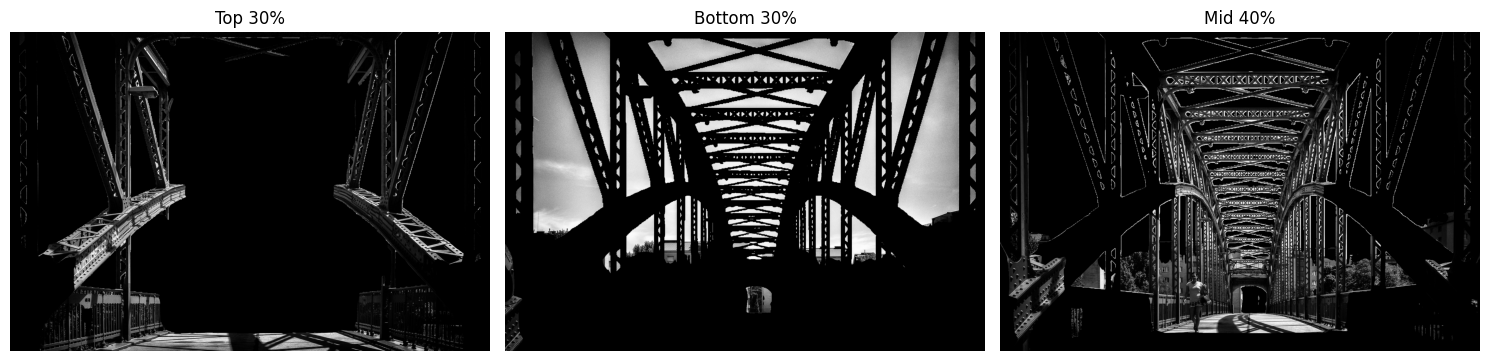

In [4]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import requests

url = "https://depth-anything-depth-anything-v2.hf.space/file=/tmp/gradio/a467d980aa8ad4c6313e1997b850522ebd33359b/demo06.jpg"
image = Image.open(requests.get(url, stream=True).raw)
# image

def make_depth_context_img(image):
    # Convert to a NumPy array
    image_array = np.array(image)

    print("Image loaded as NumPy array:")
    print(image_array.shape)

    all_outputs = on_submit(image_array)

    # Assuming image_array is the original image array and all_outputs[0][1] contains the intensity values
    intensity_image = all_outputs[0][1]  # Image from which we calculate intensity percentiles

    # Get image dimensions
    height, width, channels = image_array.shape

    # Flatten the intensity image to get a list of all pixel intensities
    flattened_intensity_image = intensity_image.reshape(-1, 3)

    # Calculate intensity values for each pixel (using the average of RGB channels)
    intensities = np.mean(flattened_intensity_image, axis=1)

    # Calculate the percentiles
    top30_threshold = np.percentile(intensities, 70)  # 70th percentile for top 30%
    bottom30_threshold = np.percentile(intensities, 30)  # 30th percentile for bottom 30%
    
    # Create masks based on the intensity thresholds
    top30_mask_flat = intensities > top30_threshold
    bottom30_mask_flat = intensities < bottom30_threshold
    mid40_mask_flat = (intensities >= bottom30_threshold) & (intensities <= top30_threshold)

    # Reshape masks to match the original image shape (height, width, channels)
    top30_mask = top30_mask_flat.reshape(height, width, 1)
    bottom30_mask = bottom30_mask_flat.reshape(height, width, 1)
    mid40_mask = mid40_mask_flat.reshape(height, width, 1)

    # Apply masks to the image_array (preserve the regions and set others to black)
    top30_image = np.where(top30_mask, image_array, 0)
    bottom30_image = np.where(bottom30_mask, image_array, 0)
    mid40_image = np.where(mid40_mask, image_array, 0)


    return [top30_image, bottom30_image, mid40_image]



import numpy as np
import matplotlib.pyplot as plt

images = make_depth_context_img(image)

# Plot the images
plt.figure(figsize=(15, 5))
titles = ['Top 30%', 'Bottom 30%', 'Mid 40%']
# images = [top30_image, bottom30_image, mid40_image]


for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()



In [5]:
import torch
from PIL import Image
from transformers import AutoProcessor, Kosmos2ForConditionalGeneration

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




2025-03-09 16:40:05.423406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741538405.437504    6380 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741538405.441820    6380 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 16:40:05.455858: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using device: cuda


In [7]:

# Load the Kosmos-2 model and processor, move the model to the GPU
processor_kosmos = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")
# model_kosmos = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224").to(DEVICE)
# model_kosmos = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224").to(device)


In [8]:
model_kosmos = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224")


In [14]:
!export CUDA_LAUNCH_BLOCKING=1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, Kosmos2ForConditionalGeneration

model = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224")
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")

url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.jpg"
image = Image.open(requests.get(url, stream=True).raw)


def get_caption_and_entities_kosmos_2(image_array):
    # Convert the numpy array image to a PIL Image
    image = Image.fromarray(image_array.astype('uint8'))

    prompt = "<grounding> An image of"

    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=64,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)

    caption, entities = processor.post_process_generation(generated_text)
    return caption, entities
    
    
caption

entities

[('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]),
 ('a fire', (41, 47), [(0.171875, 0.015625, 0.484375, 0.890625)])]

In [9]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should be >0 if GPU is available
print(torch.version.cuda)  # Ensure CUDA is installed
print(torch.backends.cudnn.version())  # Check cuDNN version


True
1
12.1
90100


In [10]:
!export CUDA_LAUNCH_BLOCKING=1


In [20]:

import numpy as np
from PIL import Image


def get_caption_and_entities_kosmos_2(image_array):
    # Convert the numpy array image to a PIL Image
    image = Image.fromarray(image_array.astype('uint8'))

    prompt = "<grounding> An image of"

    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=64,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)

    caption, entities = processor.post_process_generation(generated_text)
    return caption, entities
    


location = ["Closest","Mid Range","Farthest"]

for i in range(3):
    image = images[i]
    entities = get_caption_and_entities_kosmos_2(image)

    print(f"{location[i]}: {entities[0]}\n----")


Closest: An image of a bridge and train in black and white
----
Mid Range: An image of a bridge taken from underneath
----
Farthest: An image of a man and a dog walking across a bridge at night.
----


In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, Kosmos2ForConditionalGeneration

model = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224")
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")

In [12]:


url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.jpg"
image = Image.open(requests.get(url, stream=True).raw)

prompt = "<grounding> An image of"

inputs = processor(text=prompt, images=image, return_tensors="pt")

generated_ids = model.generate(
    pixel_values=inputs["pixel_values"],
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    image_embeds=None,
    image_embeds_position_mask=inputs["image_embeds_position_mask"],
    use_cache=True,
    max_new_tokens=64,
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
processed_text

caption, entities = processor.post_process_generation(generated_text)
caption

entities

KeyboardInterrupt: 